# Evaluate the quality of the given summaries

In [1]:
import sys
sys.path.append("../")

import text_tools
from tools import progress_bar
import pandas as pd
import json
import yaml
import matplotlib.pyplot as plt
import torch
import tools
import pickle

/home/gianluca/anaconda3/envs/thesis/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [9]:
#text_tools.MUST_C_PATH = "/media/usb4/en-cs/data"
text_tools.MUST_C_PATH = "/media/gianluca/Backups/en-cs/data"

text_tools.AMARA_PATH = "/media/gianluca/Shared/DKE/Thesis/BuildDataset/Amara"
#text_tools.AMARA_DATA_PATH = "/media/usb4/Backup - Computer/DKE/Thesis_data/Amara"
text_tools.AMARA_DATA_PATH = "/media/gianluca/RASPPI1/Backup - Computer/DKE/Thesis_data/Amara"

text_tools.TED_PATH = "/media/gianluca/Shared/DKE/Thesis/BuildDataset/TED"
text_tools.TED_DATA_PATH = "/media/gianluca/Shared/DKE/Thesis/BuildDataset/TED/Data"

In [3]:
dataset = "/home/gianluca/Documents/DKE/Thesis/BuildDataset/integrated_data.csv"

In [4]:
evaluator = text_tools.Evaluator()

In [5]:
df = pd.read_csv(dataset, index_col="id")
results = [None for i in range(df.shape[0])]  # list of (id, rouge1, rouge2, rougel)
columns = ("Id", "Descr-R1", "Descr-R2", "Descr-RL", "Title-R1", "Title-R2", "Title-RL")

In [30]:
files = {}

# read the amara data_urls
for i in text_tools.AMARA_FOLDERS:
    with open(f"{text_tools.AMARA_DATA_PATH}/{i}/data_urls.json", "r") as f:
        files[f"data_{i}"] = json.load(f)

with open(f"{text_tools.TED_DATA_PATH}/data_urls.json") as f:
    files["data_urls"] = json.load(f)

# read the talk id
files["amara_talk_id"] = pd.read_csv(f"{text_tools.AMARA_PATH}/talk_id.csv")
files["ted_talk_id"] = pd.read_csv(f"{text_tools.TED_PATH}/talk_id.csv")

# get the yaml file from the two test folders
with open(f"{text_tools.MUST_C_PATH}/tst-COMMON/txt/tst-COMMON.yaml", "r") as f1:
    with open(f"{text_tools.MUST_C_PATH}/tst-HE/txt/tst-HE.yaml", "r") as f2:    
        files["yaml"] = pd.DataFrame(yaml.full_load(f1)).append(pd.DataFrame(yaml.full_load(f2)))

with open(f"{text_tools.MUST_C_PATH}/tst-COMMON/txt/tst-COMMON.en", "r") as f1:
    with open(f"{text_tools.MUST_C_PATH}/tst-HE/txt/tst-HE.en", "r") as f2:    
        files["transcript"] = pd.DataFrame(f1.readlines()).append(pd.DataFrame(f2.readlines()))

progress_bar(0, "Evaluating", df.shape[0])
missing = []
for i, id_ in enumerate(df.index):
    set_ = None
    #if df.loc[id_, "must_c"]: # -> Not title or description
    #    set_ = text_tools.DATASETS.Mustc
    if df.loc[id_, "ted"]:
        set_ = text_tools.DATASETS.Ted
    elif df.loc[id_, "amara"]:
        set_ = text_tools.DATASETS.Amara
    else:
        #print("CANNOT FIND THE SET: skip", id_)
        pass
    if set_ is not None:
        try:
            transcript, title, description = text_tools.get_transcript(id_, set_, **files)
        except IndexError:
            #print("Can't find transcript:", id_)
            missing.append(id_)
        try:
            rd = evaluator.evaluate([description], [transcript])
            rt = evaluator.evaluate([title], [transcript])
        except ValueError:
            #print("Error on id", id_, ":", transcript)
            pass
        results[i] = (id_, rd["rouge-1"]["f"], rd["rouge-2"]["f"], rd["rouge-l"]["f"], rt["rouge-1"]["f"], rt["rouge-2"]["f"], rt["rouge-l"]["f"])
    progress_bar(i+1, "Evaluating", df.shape[0])

results = pd.DataFrame(results, columns=columns)
results

Evaluating: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% - 10876/10876


,Id,Descr-R1,Descr-R2,Descr-RL,Title-R1,Title-R2,Title-RL
0,1.0,0.020000,0.004550,0.047790,0.002771,0.001849,0.007472
1,2.0,0.018904,0.005297,0.059041,0.003824,0.000000,0.012755
2,3.0,0.016627,0.003170,0.033755,0.004006,0.000802,0.010858
3,4.0,0.010346,0.001294,0.033670,0.003256,0.000000,0.011507
4,5.0,0.014671,0.004194,0.039604,0.002646,0.000529,0.008188
...,...,...,...,...,...,...,...
10871,-6835.0,0.098655,0.000000,0.113208,0.035714,0.012048,0.052632
10872,-6836.0,0.014006,0.004205,0.036452,0.005640,0.002116,0.019827
10873,-6837.0,0.021491,0.005380,0.052539,0.004101,0.002738,0.010989
10874,-6838.0,0.024096,0.001609,0.034602,0.006557,0.000000,0.010811


In [31]:
results.to_csv("rouge.csv")

In [32]:
len(missing)

1977

## Analysis of the Rouge scores

In [32]:
results = pd.read_csv("rouge_transcript_hyp.csv", index_col="Id")  # Summary model: no summary
results = results.drop("Unnamed: 0", 1)

In [33]:
results

,Descr-R1,Descr-R2,Descr-RL,Title-R1,Title-R2,Title-RL
Id,,,,,,
1.0,0.020000,0.004550,0.047790,0.002771,0.001849,0.007472
2.0,0.018904,0.005297,0.059041,0.003824,0.000000,0.012755
3.0,0.016627,0.003170,0.033755,0.004006,0.000802,0.010858
4.0,0.010346,0.001294,0.033670,0.003256,0.000000,0.011507
5.0,0.014671,0.004194,0.039604,0.002646,0.000529,0.008188
...,...,...,...,...,...,...
-6835.0,0.098655,0.000000,0.113208,0.035714,0.012048,0.052632
-6836.0,0.014006,0.004205,0.036452,0.005640,0.002116,0.019827
-6837.0,0.021491,0.005380,0.052539,0.004101,0.002738,0.010989


In [34]:
results.describe()

,Descr-R1,Descr-R2,Descr-RL,Title-R1,Title-R2,Title-RL
count,10872.000000,10872.000000,10872.000000,10872.000000,10872.000000,10872.000000
mean,0.065397,0.018972,0.097663,0.007470,0.002406,0.017340
std,0.045194,0.023886,0.046934,0.007689,0.004411,0.013033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032358,0.006250,0.064121,0.003542,0.000000,0.009988
50%,0.053735,0.011900,0.090134,0.005760,0.001399,0.015038
75%,0.086555,0.021235,0.122295,0.009204,0.003203,0.021949
max,0.431818,0.231939,0.456954,0.307692,0.240000,0.500000


([<matplotlib.axis.XTick at 0x7fbe619b2d00>,
 [Text(1, 0, 'Rouge-1'), Text(2, 0, 'Rouge-2'), Text(3, 0, 'Rouge-L')])

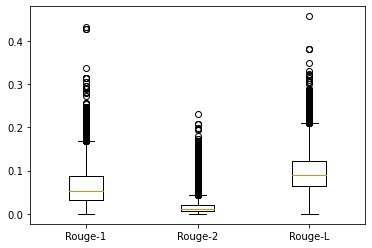

In [35]:
#plt.boxplot([1,2,3], results[["Descr-R1", "Descr-R2", "Descr-RL"]])
plt.boxplot([results[results["Descr-R1"].notna()]["Descr-R1"],
            results[results["Descr-R2"].notna()]["Descr-R2"],
            results[results["Descr-RL"].notna()]["Descr-RL"]])
plt.xticks([1,2,3], ["Rouge-1", "Rouge-2", "Rouge-L"])

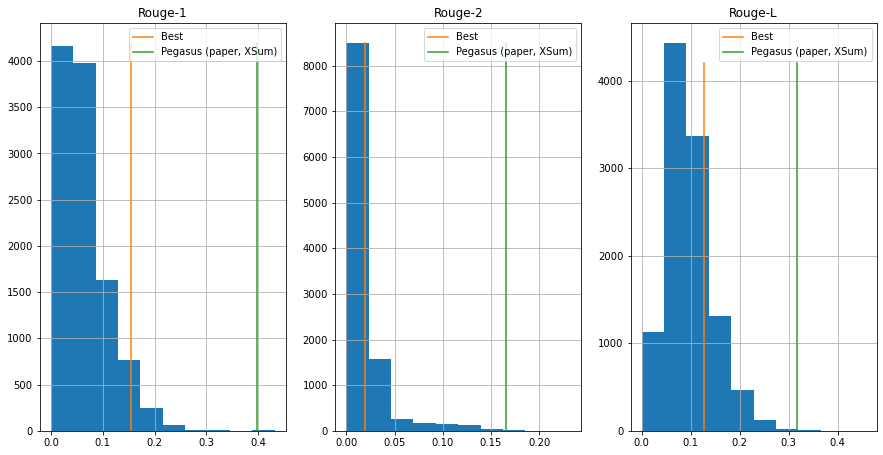

In [57]:
plt.figure(figsize=(15,7.5))
plt.subplot(1, 3, 1)
plt.title("Rouge-1")
results["Descr-R1"].hist()
plt.plot([0.1546, 0.1546], [0,4200], label="Best")
plt.plot([0.3979, 0.3979], [0,4200], label="Pegasus (paper, XSum)")
plt.legend(loc=1)

plt.subplot(1, 3, 2)
plt.title("Rouge-2")
results["Descr-R2"].hist()
plt.plot([0.0195, 0.0195], [0,8500], label="Best")
plt.plot([0.1658, 0.1658], [0,8500], label="Pegasus (paper, XSum)")
plt.legend(loc=1)

plt.subplot(1, 3, 3)
plt.title("Rouge-L")
results["Descr-RL"].hist()
plt.plot([0.127, 0.127], [0,4200], label="Best")
plt.plot([0.317, 0.317], [0,4200], label="Pegasus (paper, XSum)")
plt.legend(loc=1)

([<matplotlib.axis.XTick at 0x7fbe5fd69280>,
 [Text(1, 0, 'Rouge-1'), Text(2, 0, 'Rouge-2'), Text(3, 0, 'Rouge-L')])

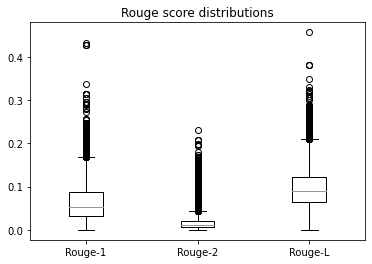

In [59]:
plt.boxplot([ # doesn't work otherwise
    results[results["Descr-R1"] < 1]["Descr-R1"],
    results[results["Descr-R2"] < 1]["Descr-R2"],
    results[results["Descr-RL"] < 1]["Descr-RL"],
])
plt.title("Rouge score distributions")
plt.xticks([1,2,3], ["Rouge-1", "Rouge-2", "Rouge-L"])

# Extractive fragments

In [7]:
from newsroom.analyze import Fragments
#f = Fragments(summary_str, text_str)
#print("Coverage:",    f.coverage())
#print("Density:",     f.density())
#print("Compression:", f.compression())

In [9]:
files = {}

# read the amara data_urls
for i in text_tools.AMARA_FOLDERS:
    with open(f"{text_tools.AMARA_DATA_PATH}/{i}/data_urls.json", "r") as f:
        files[f"data_{i}"] = json.load(f)

with open(f"{text_tools.TED_DATA_PATH}/data_urls.json") as f:
    files["data_urls"] = json.load(f)

# read the talk id
files["amara_talk_id"] = pd.read_csv(f"{text_tools.AMARA_PATH}/talk_id.csv")
files["ted_talk_id"] = pd.read_csv(f"{text_tools.TED_PATH}/talk_id.csv")

# get the yaml file from the two test folders
with open(f"{text_tools.MUST_C_PATH}/tst-COMMON/txt/tst-COMMON.yaml", "r") as f1:
    with open(f"{text_tools.MUST_C_PATH}/tst-HE/txt/tst-HE.yaml", "r") as f2:    
        files["yaml"] = pd.DataFrame(yaml.full_load(f1)).append(pd.DataFrame(yaml.full_load(f2)))

with open(f"{text_tools.MUST_C_PATH}/tst-COMMON/txt/tst-COMMON.en", "r") as f1:
    with open(f"{text_tools.MUST_C_PATH}/tst-HE/txt/tst-HE.en", "r") as f2:    
        files["transcript"] = pd.DataFrame(f1.readlines()).append(pd.DataFrame(f2.readlines()))

progress_bar(0, "Evaluating", df.shape[0])
ext = [None for i in df.index]
for i, id_ in enumerate(df.index):
    set_ = None
    if df.loc[id_, "ted"]:
        set_ = text_tools.DATASETS.Ted
    elif df.loc[id_, "amara"]:
        set_ = text_tools.DATASETS.Amara
    else:
        #print("CANNOT FIND THE SET: skip", id_)
        pass
    if set_ is not None:
        try:
            transcript, title, description = text_tools.get_transcript(id_, set_, **files)
        except IndexError:
            pass
        try:
            f = Fragments(description, transcript)
        except ValueError:
            print("Error on id", id_, ":", transcript)            
        ext[i] = [id_, f.coverage(), f.density(), f.compression()]
    progress_bar(i+1, "Evaluating", df.shape[0])

ext = pd.DataFrame([i for i in ext if i is not None], columns = ["id", "coverage", "density", "compression"])
ext

Evaluating: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% - 10876/10876


,id,coverage,density,compression
0,1,0.688889,0.911111,64.688889
1,2,0.731707,1.317073,81.268293
2,3,0.690476,0.976190,78.380952
3,4,0.687500,0.812500,122.500000
4,5,0.782609,1.173913,106.782609
...,...,...,...,...
10867,-6835,0.383562,0.547945,3.931507
10868,-6836,0.674419,1.046512,88.348837
10869,-6837,0.500000,0.700000,49.025000
10870,-6838,0.552632,0.763158,43.000000


In [12]:
ext.to_csv("Extractive.csv")

In [2]:
ext = pd.read_csv("Extractive.csv").drop(["Unnamed: 0"], axis=1)
ext

,id,coverage,density,compression
0,1,0.688889,0.911111,64.688889
1,2,0.731707,1.317073,81.268293
2,3,0.690476,0.976190,78.380952
3,4,0.687500,0.812500,122.500000
4,5,0.782609,1.173913,106.782609
...,...,...,...,...
10867,-6835,0.383562,0.547945,3.931507
10868,-6836,0.674419,1.046512,88.348837
10869,-6837,0.500000,0.700000,49.025000
10870,-6838,0.552632,0.763158,43.000000


Text(0.5, 1.0, 'Extractive fragments coverage & density')

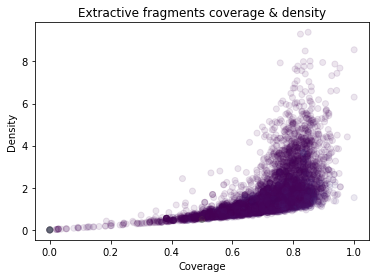

In [25]:
plt.scatter(ext.coverage, ext.density, alpha=0.1)
plt.xlabel("Coverage")
plt.ylabel("Density")
plt.title("Extractive fragments coverage & density")

Text(0.5, 0, 'Coverage')

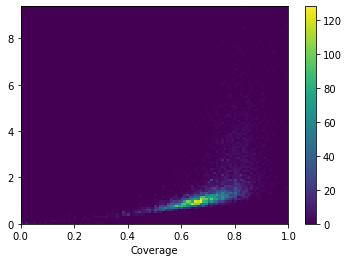

In [24]:
plt.hist2d(ext.coverage, ext.density, (100, 100))
plt.colorbar()
plt.xlabel("Coverage")

Text(0.5, 0, 'Compression')

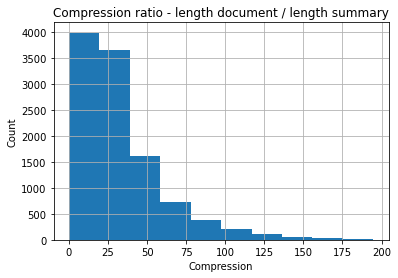

In [29]:
ext[ext.compression < 200].compression.hist()
plt.title("Compression ratio - length document / length summary")
plt.ylabel("Count")
plt.xlabel("Compression")

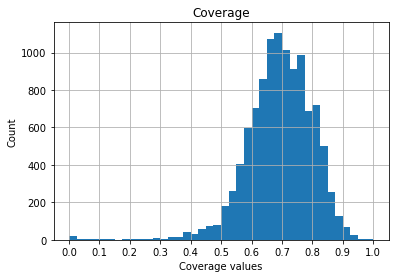

In [7]:
ext["coverage"].hist(bins=40)
plt.title("Coverage")
plt.xlabel("Coverage values")
plt.ylabel("Count")
plt.xticks([0.1*i for i in range(11)])
plt.show()

# Select some examples

In [27]:
ext = pd.read_csv("Extractive.csv").drop(["Unnamed: 0"], axis=1)
ext

,id,coverage,density,compression
0,1,0.688889,0.911111,64.688889
1,2,0.731707,1.317073,81.268293
2,3,0.690476,0.976190,78.380952
3,4,0.687500,0.812500,122.500000
4,5,0.782609,1.173913,106.782609
...,...,...,...,...
10867,-6835,0.383562,0.547945,3.931507
10868,-6836,0.674419,1.046512,88.348837
10869,-6837,0.500000,0.700000,49.025000
10870,-6838,0.552632,0.763158,43.000000


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
n = 10
low_cov_low_den = [0, 0.1, 0, 0.5]
hi_cov_low_den = [0.7, 1, 0, 1.5]
hi_cov_hi_den = [0.7, 1, 6, 10]
compression = [2, 100] # upper bound is arbitrary

def mask(lim, comp = compression, df = ext):
    m = (df["compression"] >= compression[0]) & (df["compression"] <= compression[1])
    m = (df["coverage"] >= lim[0]) & (df["coverage"] <= lim[1]) & m
    m = (df["density"] >= lim[2]) & (df["density"] <= lim[3]) & m
    return m

m_low_low = mask(low_cov_low_den)
m_hi_low = mask(hi_cov_low_den)
m_hi_hi = mask(hi_cov_hi_den)

In [15]:
print("Low coverage - Low density:", ext[m_low_low].shape[0])
print("High coverage - Low density:", ext[m_hi_low].shape[0])
print("High coverage - High density:", ext[m_hi_hi].shape[0])

Low coverage - Low density: 4
High coverage - Low density: 2840
High coverage - High density: 43


In [16]:
model = text_tools.SimpleSummarizationModel(device)
base_pipeline = tools.get_pipeline(
    text_tools.preprocess_numbers,
    text_tools.preprocess_spaces,
    text_tools.preprocess_clean
)

In [57]:
files = {}
for i in text_tools.AMARA_FOLDERS:
    with open(f"{text_tools.AMARA_DATA_PATH}/{i}/data_urls.json", "r") as f:
        files[f"data_{i}"] = json.load(f)

    with open(f"{text_tools.TED_DATA_PATH}/data_urls.json") as f:
        files["data_urls"] = json.load(f)

# read the talk id
files["amara_talk_id"] = pd.read_csv(f"{text_tools.AMARA_PATH}/talk_id.csv")
files["ted_talk_id"] = pd.read_csv(f"{text_tools.TED_PATH}/talk_id.csv")

# get the yaml file from the two test folders
with open(f"{text_tools.MUST_C_PATH}/tst-COMMON/txt/tst-COMMON.yaml", "r") as f1:
    with open(f"{text_tools.MUST_C_PATH}/tst-HE/txt/tst-HE.yaml", "r") as f2:    
        files["yaml"] = pd.DataFrame(yaml.full_load(f1)).append(pd.DataFrame(yaml.full_load(f2)))

with open(f"{text_tools.MUST_C_PATH}/tst-COMMON/txt/tst-COMMON.en", "r") as f1:
    with open(f"{text_tools.MUST_C_PATH}/tst-HE/txt/tst-HE.en", "r") as f2:    
        files["transcript"] = pd.DataFrame(f1.readlines()).append(pd.DataFrame(f2.readlines()))

def compute_examples(df, n, model, pipeline, dataset):
    output = {}
    
    for i, id_ in enumerate(df["id"]):
        if i >= n:
            break
        else:
            set_ = None
            if dataset.loc[id_, "ted"]:
                set_ = text_tools.DATASETS.Ted
            elif dataset.loc[id_, "amara"]:
                set_ = text_tools.DATASETS.Amara
            else:
                #set_ = text_tools.DATASETS.Mustc
                pass
            try:
                transcript, _, description = text_tools.get_transcript(id_, set_, **files)
            except IndexError:
                print("Missing index:", id_)
            
            summ = model.predict(pipeline([transcript]))[0]
            output[id_] = {
                "description": description,
                "summary": summ,
                "transcript": transcript
            }
    return output

In [60]:
with open("low_coverage_low_density_examples.json", "w") as f:
    json.dump(compute_examples(ext[m_low_low], n, model, base_pipeline, df), f, indent=4)
    
with open("high_coverage_low_density_examples.json", "w") as f:
    json.dump(compute_examples(ext[m_hi_low], n, model, base_pipeline, df), f, indent=4)
    
with open("high_coverage_high_density_examples.json", "w") as f:
    json.dump(compute_examples(ext[m_hi_hi], n, model, base_pipeline, df), f, indent=4)

# Export

In [7]:
test = df[(df["test"] == True) & (df["drop"] == False)]
train = df[(df["train"] == True) & (df["drop"] == False)]
ext = pd.read_csv("Extractive.csv").drop(["Unnamed: 0"], axis=1).set_index("id")
ext

,coverage,density,compression
id,,,
1,0.688889,0.911111,64.688889
2,0.731707,1.317073,81.268293
3,0.690476,0.976190,78.380952
4,0.687500,0.812500,122.500000
5,0.782609,1.173913,106.782609
...,...,...,...
-6835,0.383562,0.547945,3.931507
-6836,0.674419,1.046512,88.348837
-6837,0.500000,0.700000,49.025000


In [17]:
def make(files, df):
    docs = []
    targets = []
    progress_bar(0, "Building", df.shape[0])
    for i in range(df.shape[0]):
        id_ = df.iloc[i].name
        set_ = None
        if df.iloc[i]["ted"]:
            set_ = text_tools.DATASETS.Ted
        elif df.iloc[i]["amara"]:
            set_ = text_tools.DATASETS.Amara
        elif df.iloc[i]["must_c"]:
            set_ = text_tools.DATASETS.Mustc
        else:
            print("CANNOT FIND THE SET")
        # Filter on coverage
        if set_ is not None and id_ in ext.index:
            if ext.loc[id_, "coverage"] >= 0.5:
                transcript, _, description = text_tools.get_transcript(id_, set_, **files)
                docs.append(transcript)
                targets.append(description)
        progress_bar(i+1, "Building", df.shape[0])
    print("\nDataset size:", len(targets))
    return docs, targets

files = text_tools.get_files()

doc_test, target_test = make(files, test)
doc_train, target_train = make(files, train)

Building: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% - 1183/1183

Dataset size: 1152
Building: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% - 7679/7679

Dataset size: 7423


In [18]:
with open("filter_test_documents.pkl", "wb") as f:
    pickle.dump(doc_test, f)
with open("filter_test_targets.pkl", "wb") as f:
    pickle.dump(target_test, f)

In [11]:
del doc_test
del target_test

In [19]:
with open("filter_train_documents.pkl", "wb") as f:
    pickle.dump(doc_train, f)
with open("filter_train_targets.pkl", "wb") as f:
    pickle.dump(target_train, f)

In [14]:
del doc_train
del target_train

# Dataset statistics

In [11]:
# -Original and cov >= 0.5
# text length
# reference summary length
# -count bigrams
# -bigrams overlapping
# -count set size
import text_tools
from nltk import word_tokenize 
from nltk.util import ngrams
import tools
from collections import defaultdict
from importlib import reload
import matplotlib.pyplot as plt
files = text_tools.get_files()
cov = pd.read_csv("Extractive.csv")[["id", "coverage", "density", "compression"]]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1]:
#reload(text_tools)

In [12]:
pipeline = tools.get_pipeline(
    text_tools.preprocess_numbers,
    text_tools.preprocess_spaces,
    text_tools.preprocess_clean
)
selected = df.loc[cov[cov["coverage"] >=0.5]["id"]]
#model = text_tools.SimpleSummarizationModel("cpu")

In [10]:
print("Original test set size:", (df["test"] & ~df["drop"]).sum())
print("Original train set size:", (df["train"] & ~df["drop"]).sum())
print("Filtered test set size:", (selected["test"] & ~selected["drop"]).sum())
print("Filtered train set size:", (selected["train"] & ~selected["drop"]).sum())
print("Removed:", (cov["coverage"] < 0.5).sum())

Original test set size: 1183
Original train set size: 7679
Filtered test set size: 1152
Filtered train set size: 7423
Removed: 386


In [63]:
test_sum_len = [(0, -1, -1) for i in range((df["test"] & ~df["drop"]).sum())] # id, length, unique words
test_counter = 0

# document
train_doc_bi = defaultdict(int)
test_doc_bi = defaultdict(int)
filter_train_doc_bi = defaultdict(int)
filter_test_doc_bi = defaultdict(int)

# target
train_tar_bi = defaultdict(int)
test_tar_bi = defaultdict(int)
filter_train_tar_bi = defaultdict(int)
filter_test_tar_bi = defaultdict(int)

# document
train_doc = defaultdict(int)
test_doc = defaultdict(int)
filter_train_doc = defaultdict(int)
filter_test_doc = defaultdict(int)

# target
train_tar = defaultdict(int)
test_tar = defaultdict(int)
filter_train_tar = defaultdict(int)
filter_test_tar = defaultdict(int)

# length
doc_len = [(0, -1) for i in range(df.shape[0])]
tar_len = [(0, -1) for i in range(df.shape[0])]

tools.progress_bar(0, "Sample", df.shape[0])
for i, id_ in enumerate(df.index):
    if not df.loc[id_, "drop"]:
        set_ = None
        if df.loc[id_, "ted"]:
            set_ = text_tools.DATASETS.Ted
        elif df.loc[id_, "amara"]:
            set_ = text_tools.DATASETS.Amara
        else:
            set_ = text_tools.DATASETS.Mustc
            pass
        try:
            transcript, _, description = text_tools.get_transcript(id_, set_, **files)            
        except IndexError:
            print("Missing index:", id_)
        
        doc = pipeline([transcript])[0]
        tar = pipeline([description])[0]
        
        #if df.loc[id_, "test"]:
        #    summ = model.predict(doc)[0]
        #    summ = word_tokenize(summ)
        #    test_sum_len[test_counter] = (id_, len(summ), len(set(summ)))
        #    test_counter += 1
        if len(doc) != 0 and len(tar) !=0:
            #doc = doc[0]
            #tar = tar[0]
            doc_tok = word_tokenize(doc)
            tar_tok = word_tokenize(tar)
        
            doc_uni = list(ngrams(doc_tok, 1, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
            tar_uni = list(ngrams(tar_tok, 1, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
            doc_bi = list(ngrams(doc_tok, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
            tar_bi = list(ngrams(tar_tok, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))

            doc_len[i] = (id_, len(doc_tok))
            tar_len[i] = (id_, len(tar_tok))

            if df.loc[id_, "test"]:
                for j in doc_bi:
                    test_doc_bi[j] += 1
                for j in doc_uni:
                    test_doc[j] += 1
                for j in tar_bi:
                    test_tar_bi[j] += 1
                for j in tar_uni:
                    test_tar[j] += 1
                if id_ in selected.index:
                    for j in doc_bi:
                        filter_test_doc_bi[j] += 1
                    for j in doc_uni:
                        filter_test_doc[j] += 1
                    for j in tar_bi:
                        filter_test_tar_bi[j] += 1
                    for j in tar_uni:
                        filter_test_tar[j] += 1
            if df.loc[id_, "train"]:
                for j in doc_bi:
                    train_doc_bi[j] += 1
                for j in doc_uni:
                    train_doc[j] += 1
                for j in tar_bi:
                    train_tar_bi[j] += 1
                for j in tar_uni:
                    train_tar[j] += 1
                if id_ in selected.index:
                    for j in doc_bi:
                        filter_train_doc_bi[j] += 1
                    for j in doc_uni:
                        filter_train_doc[j] += 1
                    for j in tar_bi:
                        filter_train_tar_bi[j] += 1
                    for j in tar_uni:
                        filter_train_tar[j] += 1
        tools.progress_bar(i+1, "Sample", df.shape[0])

Sample: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% - 10876/10876


In [64]:
with open("stats_tmp.pkl", "wb") as f:
    tmp = [ train_doc_bi,
        test_doc_bi,
        filter_train_doc_bi,
        filter_test_doc_bi,

        train_tar_bi,
        test_tar_bi,
        filter_train_tar_bi,
        filter_test_tar_bi,

        train_doc,
        test_doc,
        filter_train_doc,
        filter_test_doc,

        train_tar,
        test_tar,
        filter_train_tar,
        filter_test_tar,

        doc_len,
        tar_len
    ]
    pickle.dump(tmp, f)

In [7]:
with open("stats_tmp.pkl", "rb") as f:
    train_doc_bi, *others = pickle.load(f) 
    test_doc_bi, *others = others
    filter_train_doc_bi, *others = others
    filter_test_doc_bi, *others = others
    
    train_tar_bi, *others = others
    test_tar_bi, *others = others
    filter_train_tar_bi, *others = others
    filter_test_tar_bi, *others = others
    
    train_doc, *others = others
    test_doc, *others = others
    filter_train_doc, *others = others
    filter_test_doc, *others = others

    train_tar, *others = others
    test_tar, *others = others
    filter_train_tar, *others = others
    filter_test_tar, *others = others

    doc_len, *others = others
    tar_len, *others = others

In [8]:
doc_len = pd.DataFrame(doc_len, columns=["id", "len"]).set_index("id")
tar_len = pd.DataFrame(tar_len, columns=["id", "len"]).set_index("id")

In [77]:
# overlapping and count
# Bigrams
print("Unique bigrams (training documents):", len(train_doc_bi))
print("Unique bigrams (filtered training documents):", len(filter_train_doc_bi))
print("Unique bigrams (testing documents):", len(test_doc_bi))
print("Unique bigrams (filtered testing documents):", len(filter_test_doc_bi))
print()
print("Unique bigrams (training targets):", len(train_tar_bi))
print("Unique bigrams (filtered training targets):", len(filter_train_tar_bi))
print("Unique bigrams (testing targets):", len(test_tar_bi))
print("Unique bigrams (filtered testing targets):", len(filter_test_tar_bi))
print()
tmp = len(set(train_tar_bi.keys()).intersection(set(train_doc_bi.keys())))
print("In common target/document (training):", tmp, f"({tmp/len(train_tar_bi)*100:.2f}%)")
tmp = len(set(test_tar_bi.keys()).intersection(set(test_doc_bi.keys())))
print("In common target/document (testing):", tmp, f"({tmp/len(test_tar_bi)*100:.2f}%)")
tmp = len(set(filter_train_tar_bi.keys()).intersection(set(filter_train_doc_bi.keys())))
print("In common target/document (filtered, training):", tmp, f"({tmp/len(filter_train_tar_bi)*100:.2f}%)")
tmp = len(set(filter_test_tar_bi.keys()).intersection(set(filter_test_doc_bi.keys())))
print("In common target/document (filtered, testing):", tmp, f"({tmp/len(filter_test_tar_bi)*100:.2f}%)")

Unique bigrams (training documents): 1992828
Unique bigrams (filtered training documents): 1975404
Unique bigrams (testing documents): 529524
Unique bigrams (filtered testing documents): 526318

Unique bigrams (training targets): 250631
Unique bigrams (filtered training targets): 243984
Unique bigrams (testing targets): 58557
Unique bigrams (filtered testing targets): 57455

In common target/document (training): 151716 (60.53%)
In common target/document (testing): 33021 (56.39%)
In common target/document (filtered, training): 149439 (61.25%)
In common target/document (filtered, testing): 32676 (56.87%)


In [80]:
# overlapping and count
# Unigrams
print("Unique unigrams (training documents):", len(train_doc))
print("Unique unigrams (filtered training documents):", len(filter_train_doc))
print("Unique unigrams (testing documents):", len(test_doc))
print("Unique unigrams (filtered testing documents):", len(filter_test_doc))
print()
print("Unique unigrams (training targets):", len(train_tar))
print("Unique unigrams (filtered training targets):", len(filter_train_tar))
print("Unique unigrams (testing targets):", len(test_tar))
print("Unique unigrams (filtered testing targets):", len(filter_test_tar))
print()
tmp = len(set(train_tar.keys()).intersection(set(train_doc.keys())))
print("In common target/document (training):", tmp, f"({tmp/len(train_tar)*100:.2f}%)")
tmp = len(set(test_tar.keys()).intersection(set(test_doc.keys())))
print("In common target/document (testing):", tmp, f"({tmp/len(test_tar)*100:.2f}%)")
tmp = len(set(filter_train_tar.keys()).intersection(set(filter_train_doc.keys())))
print("In common target/document (filtered, training):", tmp, f"({tmp/len(filter_train_tar)*100:.2f}%)")
tmp = len(set(filter_test_tar.keys()).intersection(set(filter_test_doc.keys())))
print("In common target/document (filtered, testing):", tmp, f"({tmp/len(filter_test_tar)*100:.2f}%)")

Unique unigrams (training documents): 134264
Unique unigrams (filtered training documents): 133114
Unique unigrams (testing documents): 50333
Unique unigrams (filtered testing documents): 50118

Unique unigrams (training targets): 40813
Unique unigrams (filtered training targets): 39375
Unique unigrams (testing targets): 13928
Unique unigrams (filtered testing targets): 13639

In common target/document (training): 31230 (76.52%)
In common target/document (testing): 11098 (79.68%)
In common target/document (filtered, training): 30729 (78.04%)
In common target/document (filtered, testing): 10979 (80.50%)


In [9]:
doc_len = doc_len[doc_len["len"] != -1]
tar_len = tar_len[tar_len["len"] != -1]

In [10]:
df["doc_len"] = doc_len["len"]
df["tar_len"] = tar_len["len"]

In [58]:
train = df[(df["train"] == True) & (~df["drop"])]
test = df[(df["test"] == True) & (~df["drop"])]

filter_train = selected[(selected["train"] == True) & (~selected["drop"])]
filter_test = selected[(selected["test"] == True) & (~selected["drop"])]

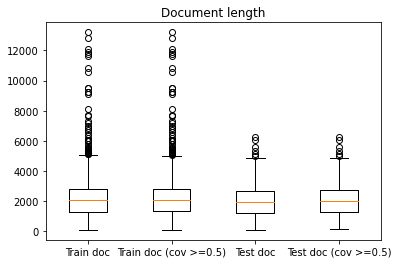

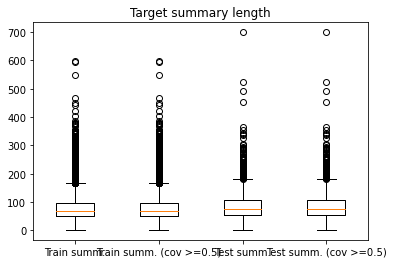

In [66]:
#train[["doc_len", "tar_len"]].plot(kind="box")
fig, ax = plt.subplots()
data = [
    train["doc_len"].dropna(),
    filter_train["doc_len"].dropna(),
    test["doc_len"].dropna(),
    filter_test["doc_len"].dropna(),
]
ax.boxplot(data, labels=["Train doc", "Train doc (cov >=0.5)", "Test doc", "Test doc (cov >=0.5)"])
ax.set_title("Document length")
plt.show()

#train[["doc_len", "tar_len"]].plot(kind="box")
fig, ax = plt.subplots()
data = [
    train["tar_len"].dropna(),
    filter_train["tar_len"].dropna(),
    test["tar_len"].dropna(),
    filter_test["tar_len"].dropna(),
]
ax.boxplot(data, labels=["Train summ.", "Train summ. (cov >=0.5)", "Test summ.", "Test summ. (cov >=0.5)"])
ax.set_title("Target summary length")
plt.show()

In [72]:
print("Target summaries")
pd.DataFrame({
    "train":train["tar_len"].dropna(),
    "filter_train":filter_train["tar_len"].dropna(),
    "test":test["tar_len"].dropna(),
    "filter_test":filter_test["tar_len"].dropna(),
}).describe()

Target summaries


,train,filter_train,test,filter_test
count,7675.000000,7423.000000,1181.000000,1152.000000
mean,85.291336,85.688536,91.528366,91.875000
std,55.662160,55.603247,61.758512,61.829858
min,2.000000,2.000000,2.000000,2.000000
25%,51.000000,51.000000,55.000000,55.000000
50%,70.000000,70.000000,75.000000,75.000000
75%,97.000000,98.000000,106.000000,106.000000
max,597.000000,597.000000,699.000000,699.000000


In [73]:
print("Documents")
pd.DataFrame({
    "train":train["doc_len"].dropna(),
    "filter_train":filter_train["doc_len"].dropna(),
    "test":test["doc_len"].dropna(),
    "filter_test":filter_test["doc_len"].dropna(),
}).describe()

Documents


,train,filter_train,test,filter_test
count,7675.000000,7423.000000,1181.000000,1152.000000
mean,2101.957655,2143.120167,2028.937341,2057.770833
std,1089.298059,1073.787740,1001.255726,988.580036
min,93.000000,115.000000,110.000000,165.000000
25%,1249.500000,1324.000000,1206.000000,1259.750000
50%,2080.000000,2109.000000,1960.000000,1987.000000
75%,2783.000000,2809.500000,2707.000000,2720.000000
max,13210.000000,13210.000000,6234.000000,6234.000000


# Filtering on the n-grams and Pegasus performance

Compute the 2-grams and 3-grams in common between the document and the reference summary. Take into account the length of the summaries.

Compute the rouge scores (reference summary and summary from Pegasus-base) and select those with the highest scores.

In [60]:
import sys
sys.path.append("../")
import text_tools
from nltk import word_tokenize 
from nltk.util import ngrams
import tools
from collections import defaultdict
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import joblib
from collections import defaultdict

pipeline = tools.get_pipeline(
    text_tools.preprocess_numbers,
    text_tools.preprocess_spaces,
    text_tools.preprocess_clean
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluator = text_tools.Evaluator(True)

In [17]:
model = text_tools.SimpleSummarizationModel("cuda")

In [2]:
# load data
test_doc = joblib.load("filter_test_documents.pkl")
test_tar = joblib.load("filter_test_targets.pkl")
train_doc = joblib.load("filter_train_documents.pkl")
train_tar = joblib.load("filter_train_targets.pkl")

if len(test_doc) != len(test_tar):
    print("Error in the test set")
if len(train_doc) != len(train_tar):
    print("Error in the train set")

In [4]:
test_doc = pipeline(test_doc)
test_tar = pipeline(test_tar)
train_doc = pipeline(train_doc)
train_tar = pipeline(train_tar)

In [5]:
# Compression ratio
test_ratio = [-1 for i in test_doc]
train_ratio = [-1 for i in train_doc]

# lengths
test_doc_len = [-1 for i in test_doc]
test_tar_len = [-1 for i in test_doc]
train_doc_len = [-1 for i in train_doc]
train_tar_len = [-1 for i in train_doc]

# 2-grams in common
test_2grams = [-1 for i in test_doc]
train_2grams = [-1 for i in train_doc]
test_doc_2grams = [-1 for i in test_doc]
test_tar_2grams = [-1 for i in test_doc]
train_doc_2grams = [-1 for i in train_doc]
train_tar_2grams = [-1 for i in train_doc]

# 3-grams in common
test_3grams = [-1 for i in test_doc]
train_3grams = [-1 for i in train_doc]
test_doc_3grams = [-1 for i in test_doc]
test_tar_3grams = [-1 for i in test_doc]
train_doc_3grams = [-1 for i in train_doc]
train_tar_3grams = [-1 for i in train_doc]


# rouges
test_r1 = [-1 for i in test_doc]
test_r2 = [-1 for i in test_doc]
test_rl = [-1 for i in test_doc]

train_r1 = [-1 for i in train_doc]
train_r2 = [-1 for i in train_doc]
train_rl = [-1 for i in train_doc]

In [15]:
def ngrams_info(doc, tar):
    doc_tok = word_tokenize(doc)
    tar_tok = word_tokenize(tar)
        
    doc2 = set(ngrams(doc_tok, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
    tar2 = set(ngrams(tar_tok, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
    doc3 = set(ngrams(doc_tok, 3, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
    tar3 = set(ngrams(tar_tok, 3, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
    
    return len(tar_tok)/len(doc_tok), len(tar_tok), len(doc_tok), len(tar2.intersection(doc2)), len(tar2), len(doc2), len(tar3.intersection(doc3)), len(tar3), len(doc3)

def get_rouge(doc, tar):
    summ = model.predict([doc])[0]
    summ = summ if summ != "." and summ != "" else "<err>"
    try:
        scores = evaluator.evaluate([tar], [summ])
    except ValueError:
        print("Error")
        print("Summary:", summ)
        print("Target:", tar)
        print("Document:", doc[:100], "...")
        scores = {"rouge-1": {"f":-1}, "rouge-2":{"f":-1}, "rouge-l":{"f":-1}}
    return scores["rouge-1"]["f"], scores["rouge-2"]["f"], scores["rouge-l"]["f"]

In [7]:
tools.progress_bar(0, "Test", len(test_tar))
for i, (doc, tar) in enumerate(zip(test_doc, test_tar)):
    tmp = ngrams_info(doc, tar)
    # length ratio
    test_ratio[i], *tmp = tmp
    # length
    test_tar_len[i], *tmp = tmp
    test_doc_len[i], *tmp = tmp
    
    # 2-grams
    test_2grams[i], *tmp = tmp
    test_tar_2grams[i], *tmp = tmp
    test_doc_2grams[i], *tmp = tmp
    
    # 3-grams
    test_3grams[i], *tmp = tmp
    test_tar_3grams[i], *tmp = tmp
    test_doc_3grams[i], *tmp = tmp
    
    test_r1[i], test_r2[i], test_rl[i] = get_rouge(doc, tar)
    tools.progress_bar(i+1, "Test", len(test_tar))
    
tools.progress_bar(0, "Train", len(test_tar))
for i, (doc, tar) in enumerate(zip(train_doc, train_tar)):
    tmp = ngrams_info(doc, tar)
    # length ratio
    train_ratio[i], *tmp = tmp
    # length
    train_tar_len[i], *tmp = tmp
    train_doc_len[i], *tmp = tmp
    
    # 2-grams
    train_2grams[i], *tmp = tmp
    train_tar_2grams[i], *tmp = tmp
    train_doc_2grams[i], *tmp = tmp
    
    # 3-grams
    train_3grams[i], *tmp = tmp
    train_tar_3grams[i], *tmp = tmp
    train_doc_3grams[i], *tmp = tmp
    
    train_r1[i], train_r2[i], train_rl[i] = get_rouge(doc, tar)
    tools.progress_bar(i+1, "Train", len(train_tar))

Test: [||||----------------------------------------------] 9.38% - 108/1152

KeyboardInterrupt: 

In [ ]:
test = pd.DataFrame({
    "ratio": test_ratio,
    "tar_len": test_tar_len,
    "doc_len": test_doc_len,
    "2grams": test_2grams,
    "tar_2grams": test_tar_2grams,
    "doc_2grams": test_doc_2grams,
    "3grams": test_3grams,
    "tar_3grams": test_tar_3grams,
    "doc_3grams": test_doc_3grams,
    "r1": test_r1,
    "r2": test_r2,
    "rl": test_rl,
})

train = pd.DataFrame({
    "ratio": train_ratio,
    "tar_len": train_tar_len,
    "doc_len": train_doc_len,
    "2grams": train_2grams,
    "tar_2grams": train_tar_2grams,
    "doc_2grams": train_doc_2grams,
    "3grams": train_3grams,
    "tar_3grams": train_tar_3grams,
    "doc_3grams": train_doc_3grams,
    "r1": train_r1,
    "r2": train_r2,
    "rl": train_rl,
})

In [23]:
test.to_csv("Filtering_test.csv")
train.to_csv("Filtering_train.csv")

In [3]:
test = pd.read_csv("Filtering_test.csv").drop(columns="Unnamed: 0", index=1)#[:500]
train = pd.read_csv("Filtering_train.csv").drop(columns="Unnamed: 0", index=1)#[:100]

In [18]:
# Fix index 1
ng = ngrams_info(test_doc[1], test_tar[1])
r = get_rouge(test_doc[1], test_tar[1])
e = evaluator.evaluate([test_tar[1]], [test_doc[1]])
test.loc[1, ["ratio", "tar_len", "doc_len", "2grams", "tar_2grams", "doc_2grams", "3grams", "tar_3grams", "doc_3grams"]] = ng
test.loc[1, ["r1", "r2", "rl"]] = r
test.loc[1, ["r1_no_model","r2_no_model", "rl_no_model"]] = e["rouge-1"]["f"], e["rouge-2"]["f"], e["rouge-l"]["f"]
test.loc[1, "2grams_prop"] = test.loc[1, "2grams"] / test.loc[1, "tar_2grams"]
test.loc[1, "3grams_prop"] = test.loc[1, "3grams"] / test.loc[1, "tar_3grams"]
test.sort_index(inplace=True)

ng = ngrams_info(test_doc[1], train_tar[1])
r = get_rouge(test_doc[1], train_tar[1])
e = evaluator.evaluate([train_tar[1]], [train_doc[1]])
train.loc[1, ["ratio", "tar_len", "doc_len", "2grams", "tar_2grams", "doc_2grams", "3grams", "tar_3grams", "doc_3grams"]] = ng
train.loc[1, ["r1", "r2", "rl"]] = r
train.loc[1, ["r1_no_model","r2_no_model", "rl_no_model"]] = e["rouge-1"]["f"], e["rouge-2"]["f"], e["rouge-l"]["f"]
train.loc[1, "2grams_prop"] = train.loc[1, "2grams"] / train.loc[1, "tar_2grams"]
train.loc[1, "3grams_prop"] = train.loc[1, "3grams"] / train.loc[1, "tar_3grams"]
train.sort_index(inplace=True)

In [9]:
print("Train doc > 512:", (train["doc_len"]>512).sum())
print("Train doc <= 512:", (train["doc_len"]<=512).sum())
print("Train doc > 1024:", (train["doc_len"]>1024).sum())
print("Train doc <= 1024:", (train["doc_len"]<=1024).sum())

print("Test doc > 512:", (test["doc_len"]>512).sum())
print("Test doc <= 512:", (test["doc_len"]<=512).sum())
print("Test doc > 1024:", (test["doc_len"]>1024).sum())
print("Test doc <= 1024:", (test["doc_len"]<=1024).sum())

Train doc > 512: 7299
Train doc <= 512: 123
Train doc > 1024: 6119
Train doc <= 1024: 1303
Test doc > 512: 1137
Test doc <= 512: 14
Test doc > 1024: 936
Test doc <= 1024: 215


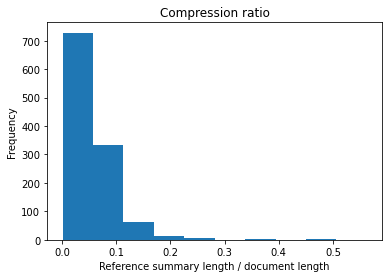

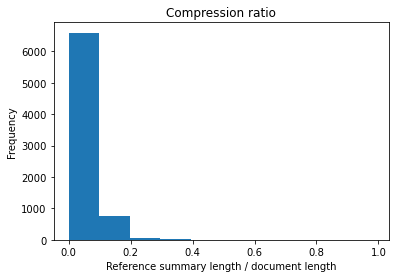

In [14]:
test["ratio"].plot(kind="hist")
plt.title("Compression ratio")
plt.xlabel("Reference summary length / document length")
plt.show()

train["ratio"].plot(kind="hist")
plt.title("Compression ratio")
plt.xlabel("Reference summary length / document length")
plt.show()

In [11]:
# Length graphs: see above

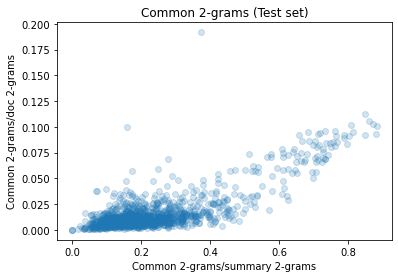

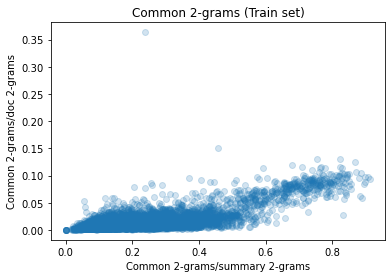

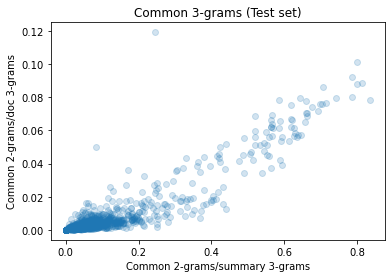

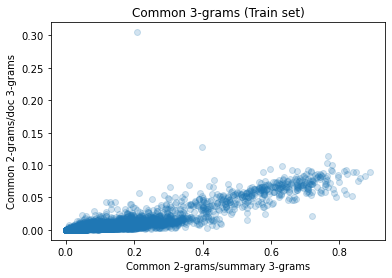

In [15]:
# Right: summary is from the document
# Left: summary has few 2grams from the doc -> abstractive or wrong
# Top: document has many 2grams in common with summ
# Bottom: difference between doc and summ

plt.scatter(test["2grams"]/test["tar_2grams"], test["2grams"]/test["doc_2grams"], alpha=0.2)
plt.title("Common 2-grams (Test set)")
plt.ylabel("Common 2-grams/doc 2-grams")
plt.xlabel("Common 2-grams/summary 2-grams")
plt.show()

plt.scatter(train["2grams"]/train["tar_2grams"], train["2grams"]/train["doc_2grams"], alpha=0.2)
plt.title("Common 2-grams (Train set)")
plt.ylabel("Common 2-grams/doc 2-grams")
plt.xlabel("Common 2-grams/summary 2-grams")
plt.show()

plt.scatter(test["3grams"]/test["tar_3grams"], test["3grams"]/test["doc_3grams"], alpha=0.2)
plt.title("Common 3-grams (Test set)")
plt.ylabel("Common 2-grams/doc 3-grams")
plt.xlabel("Common 2-grams/summary 3-grams")
plt.show()

plt.scatter(train["3grams"]/train["tar_3grams"], train["3grams"]/train["doc_3grams"], alpha=0.2)
plt.title("Common 3-grams (Train set)")
plt.ylabel("Common 2-grams/doc 3-grams")
plt.xlabel("Common 2-grams/summary 3-grams")
plt.show()

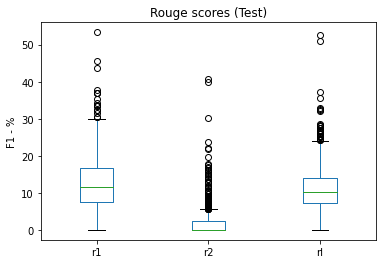

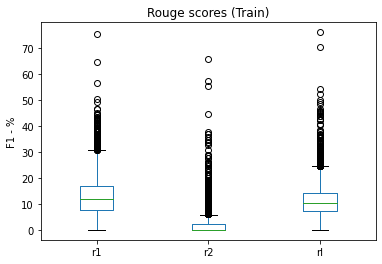

In [16]:
(test[["r1", "r2", "rl"]]*100).plot(kind="box")
plt.title("Rouge scores (Test)")
plt.ylabel("F1 - %")
plt.show()
(train[["r1", "r2", "rl"]]*100).plot(kind="box")
plt.title("Rouge scores (Train)")
plt.ylabel("F1 - %")
plt.show()
# financial-summarization-pegasus (Pegasus-base on XSUM)
# R1: 23.55 --- R2: 6.99 --- Rl: 18.14 
# Pegasus-base on XSUM - tested on C4 and HugeNews
# R1: 47.60 --- R2: 24.83 --- Rl: 39.64

In [17]:
print("Zero R1 (train):", (train["r1"]==0).sum())
print("Zero R1 (train) %:", (train["r1"]==0).sum() / len(train) * 100)
print("Zero R1 (test):", (test["r1"]==0).sum())
print("Zero R1 (test) %:", (test["r1"]==0).sum() / len(test) * 100)

print()

print("Zero R2 (train):", (train["r2"]==0).sum())
print("Zero R2 (train) %:", (train["r2"]==0).sum() / len(train) * 100)
print("Zero R2 (test):", (test["r2"]==0).sum())
print("Zero R2 (test) %:", (test["r2"]==0).sum() / len(test) * 100)

print()

print("Zero Rl (train):", (train["rl"]==0).sum())
print("Zero Rl (train) %:", (train["rl"]==0).sum() / len(train) * 100)
print("Zero Rl (test):", (test["rl"]==0).sum())
print("Zero Rl (test) %:", (test["rl"]==0).sum() / len(test) * 100)

Zero R1 (train): 302
Zero R1 (train) %: 4.068984101320399
Zero R1 (test): 48
Zero R1 (test) %: 4.170286707211121

Zero R2 (train): 4629
Zero R2 (train) %: 62.36863379143088
Zero R2 (test): 705
Zero R2 (test) %: 61.251086012163334

Zero Rl (train): 302
Zero Rl (train) %: 4.068984101320399
Zero Rl (test): 48
Zero Rl (test) %: 4.170286707211121


In [20]:
train["2grams_prop"] = train["2grams"]/train["tar_2grams"]  # proportion of 2grams in common
train["3grams_prop"] = train["3grams"]/train["tar_3grams"]  # proportion of 3grams in common
train.describe()

,ratio,tar_len,doc_len,2grams,tar_2grams,doc_2grams,3grams,tar_3grams,doc_3grams,r1,r2,rl,r1_no_model,r2_no_model,rl_no_model,2grams_prop,3grams_prop
count,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000
mean,0.051568,85.688536,2143.002694,19.219184,84.256365,1590.802910,8.385693,87.049576,1984.653509,0.126071,0.016539,0.109236,0.061146,0.019338,0.095672,0.239600,0.104137
std,0.044290,55.603247,1073.744637,14.301044,51.441981,692.346374,11.374227,54.320490,955.946501,0.072224,0.034961,0.060080,0.042425,0.025336,0.047313,0.147827,0.137504
min,0.000556,2.000000,115.000000,0.000000,3.000000,77.000000,0.000000,4.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.023791,51.000000,1324.000000,9.000000,52.000000,1050.000000,2.000000,53.000000,1247.000000,0.075949,0.000000,0.071429,0.030610,0.006058,0.061822,0.141240,0.027141
50%,0.039341,70.000000,2109.000000,15.000000,70.000000,1608.000000,4.000000,72.000000,1972.000000,0.120482,0.000000,0.103896,0.049579,0.011530,0.086604,0.203125,0.056604
75%,0.067122,98.000000,2808.000000,25.000000,97.000000,2041.500000,9.000000,99.000000,2593.000000,0.168675,0.023599,0.140845,0.078908,0.020789,0.119023,0.292308,0.116667
max,0.983539,597.000000,13210.000000,183.000000,551.000000,7152.000000,101.000000,583.000000,11150.000000,0.752688,0.659341,0.760563,0.427350,0.206897,0.380952,0.914286,0.890244


In [22]:
test["2grams_prop"] = test["2grams"]/test["tar_2grams"]  # proportion of 2grams in common
test["3grams_prop"] = test["3grams"]/test["tar_3grams"]  # proportion of 3grams in common
test.describe()

,ratio,tar_len,doc_len,2grams,tar_2grams,doc_2grams,3grams,tar_3grams,doc_3grams,r1,r2,rl,r1_no_model,r2_no_model,rl_no_model,2grams_prop,3grams_prop
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,0.056422,91.875000,2057.777778,20.335069,90.008681,1539.706597,9.186632,93.063368,1909.334201,0.124332,0.016287,0.108383,0.066673,0.021467,0.101341,0.238887,0.108234
std,0.049006,61.829858,988.580312,16.042425,56.627933,645.220550,13.068119,59.955648,883.003974,0.071402,0.034399,0.058739,0.046183,0.027928,0.050143,0.159536,0.149360
min,0.000842,2.000000,165.000000,0.000000,3.000000,152.000000,0.000000,4.000000,163.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.026546,55.000000,1259.750000,9.750000,56.000000,1004.500000,2.000000,57.000000,1183.500000,0.076364,0.000000,0.071429,0.033675,0.006647,0.066935,0.133186,0.023810
50%,0.044099,75.000000,1987.000000,16.000000,75.000000,1527.000000,4.000000,77.000000,1859.000000,0.116392,0.000000,0.103672,0.054322,0.012422,0.091364,0.193182,0.054447
75%,0.074084,106.000000,2720.000000,26.000000,105.000000,2007.000000,10.000000,108.000000,2512.500000,0.166667,0.022923,0.139535,0.086586,0.022078,0.123789,0.285714,0.114213
max,0.562771,699.000000,6234.000000,177.000000,639.000000,4403.000000,118.000000,692.000000,5741.000000,0.533333,0.406780,0.525253,0.431818,0.231939,0.456954,0.881579,0.835821


In [17]:
train[train["2grams_prop"] >= 0.13].describe() # 2grams_prop >= 1st quartile

,ratio,tar_len,doc_len,2grams,tar_2grams,doc_2grams,3grams,tar_3grams,doc_3grams,r1,r2,rl,2grams_prop,3grams_prop
count,5910.000000,5910.000000,5910.000000,5910.00000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000
mean,0.047420,82.590186,2218.787817,21.77022,81.424535,1643.580541,10.080880,84.052115,2054.403553,0.130739,0.018544,0.112500,0.276555,0.125744
std,0.037375,51.898438,1093.040885,14.61749,48.103987,697.369353,12.148802,50.758721,969.779260,0.074131,0.037698,0.062193,0.143412,0.146293
min,0.000556,4.000000,115.000000,1.00000,5.000000,77.000000,0.000000,6.000000,82.000000,0.000000,0.000000,0.000000,0.130000,0.000000
25%,0.022656,52.000000,1433.250000,11.00000,52.000000,1133.000000,3.000000,54.000000,1349.250000,0.080000,0.000000,0.072727,0.179487,0.041096
50%,0.037096,70.000000,2182.500000,17.00000,70.000000,1657.000000,6.000000,72.000000,2036.000000,0.125000,0.000000,0.107143,0.233333,0.074074
75%,0.062379,93.000000,2877.000000,28.00000,92.000000,2092.000000,12.000000,94.000000,2656.000000,0.173913,0.025974,0.144928,0.320482,0.141272
max,0.901515,595.000000,13210.000000,183.00000,551.000000,7152.000000,101.000000,583.000000,11150.000000,0.752688,0.659341,0.760563,0.914286,0.890244


In [18]:
(train["doc_len"] <= 4096).sum()

7199

In [19]:
print("Train set (filter on length, r1 and rl):", ((train["tar_len"] <= 256) & ((train["doc_len"] <= 4096)) & (train["r1"]!= 0) & (train["rl"]!= 0)).sum())
print("Train set (filter on length, r1 and rl):", ((test["tar_len"] <= 256) & ((test["doc_len"] <= 4096)) & (test["r1"]!= 0) & (test["rl"]!= 0)).sum())

Train set (filter on length, r1 and rl): 6762
Train set (filter on length, r1 and rl): 1044


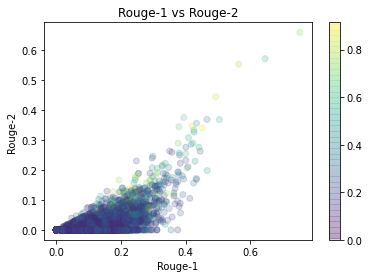

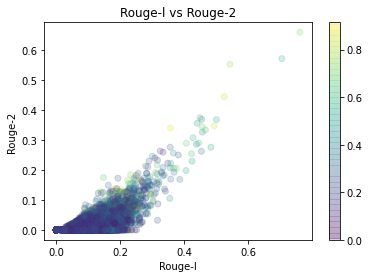

In [20]:
plt.scatter(train["r1"], train["r2"], alpha=0.2, c=train["2grams_prop"])
plt.colorbar()
plt.title("Rouge-1 vs Rouge-2")
plt.ylabel("Rouge-2")
plt.xlabel("Rouge-1")
plt.show()

plt.scatter(train["rl"], train["r2"], alpha=0.2, c=train["2grams_prop"])
plt.colorbar()
plt.title("Rouge-l vs Rouge-2")
plt.ylabel("Rouge-2")
plt.xlabel("Rouge-l")
plt.show()

Text(0.5, 1.0, 'Correlation')

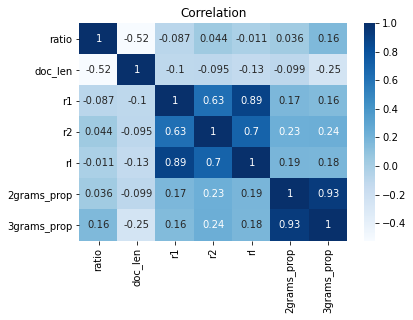

In [21]:
import seaborn as sb
corr = train[["ratio", "doc_len", "r1", "r2", "rl", "2grams_prop", "3grams_prop"]].corr()
sb.heatmap(corr, cmap="Blues", annot=True)
plt.title("Correlation")

In [22]:
# If rouge-1 or roule-l is zero -> rouge is never non-zero
filter_train = train[((train["tar_len"] <= 256) & ((train["doc_len"] <= 4096)) & (train["r1"]!= 0) & (train["rl"]!= 0) & (train["2grams_prop"] >= 0.1))]
filter_test = test[((test["tar_len"] <= 256) & ((test["doc_len"] <= 4096)) & (test["r1"]!= 0) & (test["rl"]!= 0) & (test["2grams_prop"] >= 0.10))]
print("Mean rouge-2:", filter_train["r2"].mean()*100)
print("Max rouge-2:", filter_train["r2"].max()*100)

Mean rouge-2: 1.8483229937964922
Max rouge-2: 65.93406543557543


In [23]:
filter_test.shape

(929, 14)

In [24]:
print("Rouge-2 != 0 and rouge-l == 0:", ((train["rl"] == 0) & (train["r2"] != 0)).sum())
print("Rouge-2 != 0 and rouge-1 == 0:", ((train["r1"] == 0) & (train["r2"] != 0)).sum())
print("Rouge-2 != 0 and 2grams_prop < 0.1:", ((train["2grams_prop"] < 0.1) & (train["r2"] != 0)).sum())
print("Avg rouge-2 when 2grams_prop < 0.1", train[((train["2grams_prop"] < 0.1) & (train["r2"] != 0))]["r2"].mean())
train["r2"].mean()

Rouge-2 != 0 and rouge-l == 0: 0
Rouge-2 != 0 and rouge-1 == 0: 0
Rouge-2 != 0 and 2grams_prop < 0.1: 194
Avg rouge-2 when 2grams_prop < 0.1 0.026329504803288037


0.01654145970147248

In [25]:
# Filtering on 2grams_prop still increase the avg rouge score
filter_train = train[((train["tar_len"] <= 256) & ((train["doc_len"] <= 4096)) & (train["r1"]!= 0) & (train["rl"]!= 0))]
filter_test = test[((test["tar_len"] <= 256) & ((test["doc_len"] <= 4096)) & (test["r1"]!= 0) & (test["rl"]!= 0))]
print("Mean rouge-2:", filter_train["r2"].mean()*100)
print("Max rouge-2:", filter_train["r2"].max()*100)

Mean rouge-2: 1.738847777685898
Max rouge-2: 65.93406543557543


In [26]:
# Filtering on the length increase the avg rouge score
filter_train = train[((train["r1"]!= 0) & (train["rl"]!= 0))]
filter_test = test[((test["r1"]!= 0) & (test["rl"]!= 0))]
print("Mean rouge-2:", filter_train["r2"].mean()*100)
print("Max rouge-2:", filter_train["r2"].max()*100)

Mean rouge-2: 1.7243077795551787
Max rouge-2: 65.93406543557543


In [27]:
# Filtering on ratio slightly increase the rouge
filter_train = train[(
    (train["tar_len"] <= 256) & 
    ((train["doc_len"] <= 4096)) & 
    (train["r1"]!= 0) & (train["rl"]!= 0) & 
    (train["2grams_prop"] >= 0.1) & 
    (train["ratio"] <= 0.4))]
filter_test = test[(
    (test["tar_len"] <= 256) & 
    ((test["doc_len"] <= 4096)) & 
    (test["r1"]!= 0) & (test["rl"]!= 0) & 
    (test["2grams_prop"] >= 0.10)  & 
    (test["ratio"] <= 0.4))]
print("Mean rouge-2:", filter_train["r2"].mean()*100)
print("Max rouge-2:", filter_train["r2"].max()*100)
print("Train shape:", filter_train.shape)
print("Test shape:", filter_test.shape)

Mean rouge-2: 1.8489298967660526
Max rouge-2: 65.93406543557543
Train shape: (6091, 14)
Test shape: (927, 14)


In [28]:
test[test["r2"] !=0]["r2"].mean()

0.0419848772990111

In [29]:
# Filtering on ratio slightly increase the rouge
filter_train = train[(
    (train["tar_len"] <= 256) &
    (train["tar_len"] >= 5) &
    ((train["doc_len"] <= 4096)) & 
    ((train["doc_len"] >= 10)) & 
    (train["r1"]!= 0) & (train["rl"]!= 0) & 
    (train["2grams_prop"] >= 0.1)
    )]
filter_test = test[(
    (test["tar_len"] <= 256) & 
    (test["tar_len"] >= 5) & 
    ((test["doc_len"] <= 4096)) & 
    ((test["doc_len"] >= 10)) & 
    (test["r1"]!= 0) & (test["rl"]!= 0) & 
    (test["2grams_prop"] >= 0.10)
    )]
print("Mean rouge-2:", filter_train["r2"].mean()*100)
print("Max rouge-2:", filter_train["r2"].max()*100)
print("Train shape:", filter_train.shape)
print("Test shape:", filter_test.shape)

Mean rouge-2: 1.8483229937964922
Max rouge-2: 65.93406543557543
Train shape: (6093, 14)
Test shape: (929, 14)


In [30]:
train.shape

(7422, 14)

In [31]:
test.shape

(1151, 14)

In [23]:
filter_train = train[(train["tar_len"] <= 256) &
    (train["tar_len"] >= 5) &
    ((train["doc_len"] <= 4096)) & 
    ((train["doc_len"] >= 10))]

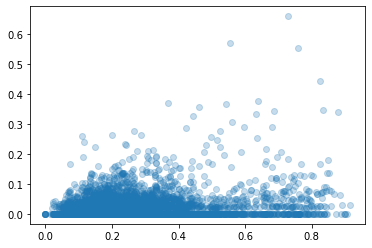

In [24]:
plt.scatter(filter_train["2grams_prop"], filter_train["r2"], alpha=0.25)
#plt.plot([0,1], [0,1])
plt.show()

In [54]:
mask = (filter_train["2grams_prop"] >= 0.2)
print("Selected:", mask.sum())
print("Avg R-2:", filter_train[mask]["r2"].mean())

Selected: 3675
Avg R-2: 0.021665626158862136


In [58]:
train.columns

Index(['ratio', 'tar_len', 'doc_len', '2grams', 'tar_2grams', 'doc_2grams',
       '3grams', 'tar_3grams', 'doc_3grams', 'r1', 'r2', 'rl', '2grams_prop',
       '3grams_prop'],
      dtype='object')

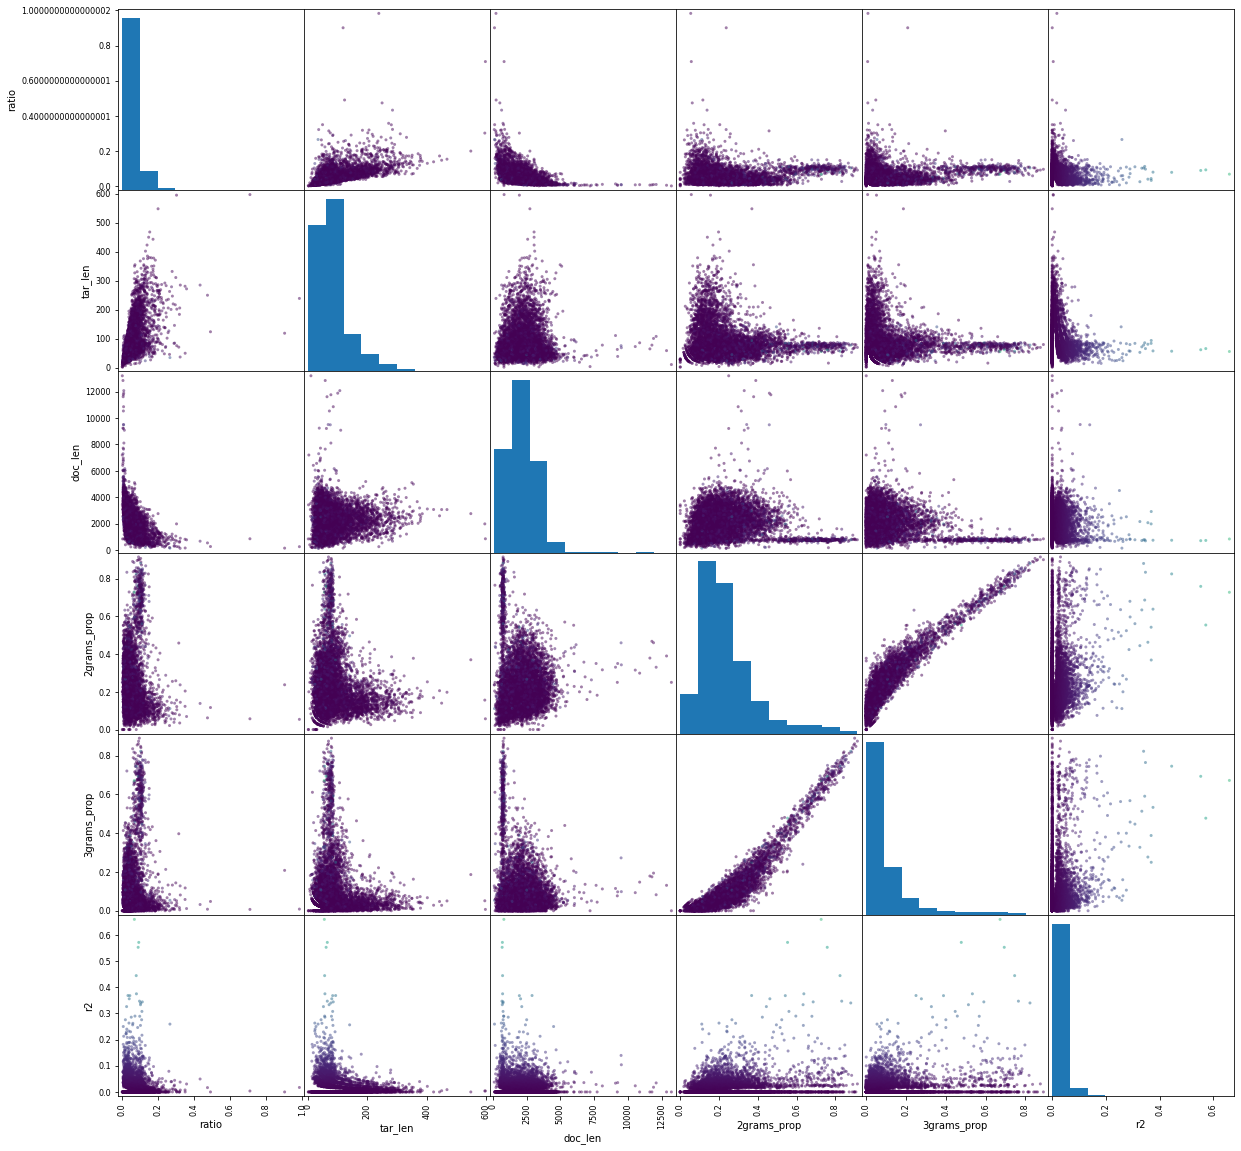

In [25]:
pd.plotting.scatter_matrix(train[["ratio", "tar_len", "doc_len", "2grams_prop", "3grams_prop", "r2"]],figsize=(20,20), c=train["r2"], alpha=0.5, vmin=0, vmax=1)
plt.show()

In [70]:
# doc <= 4096, tar <= 128
mask = (train["tar_len"] <= 128) & (train["doc_len"] <= 4096) & (train["ratio"] <= 0.15)# & (train["r2"] >= 0.2)
train[mask]["r2"].mean()

0.3049705415230774

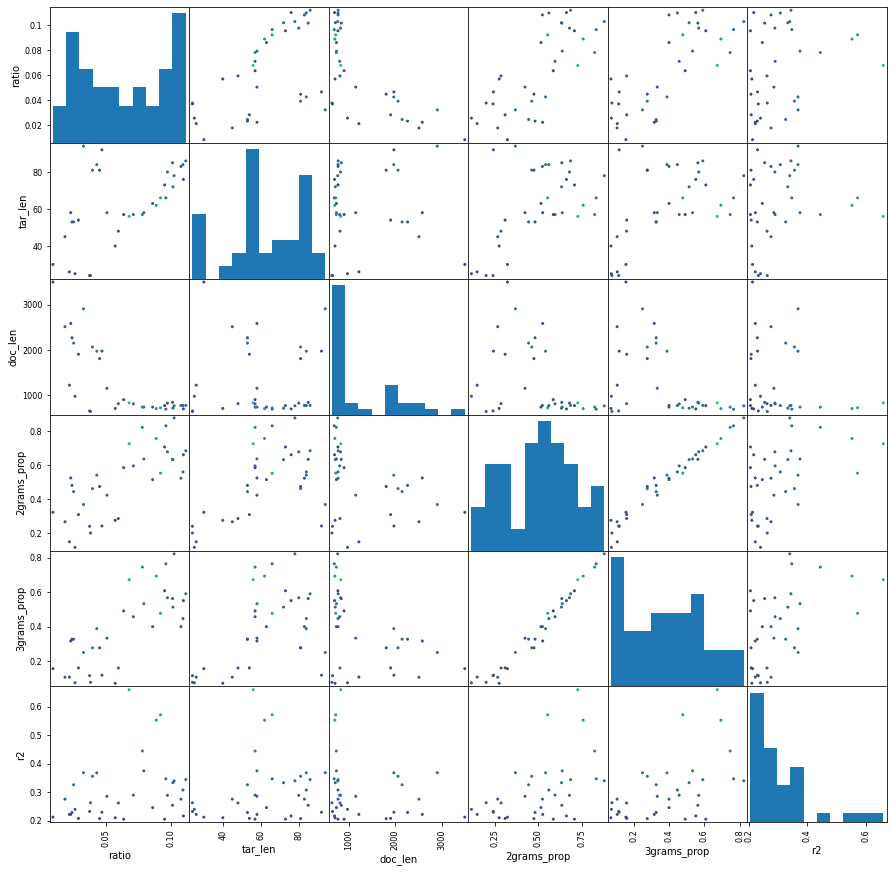

In [72]:
pd.plotting.scatter_matrix(train[mask][["ratio", "tar_len", "doc_len", "2grams_prop", "3grams_prop", "r2"]],figsize=(15,15), c=train[mask]["r2"], alpha=.5, vmin=0, vmax=1)
plt.show()

In [26]:
# 2grams_prop >= 0.3, 3grams_prop >=0.25
mask = (train["tar_len"] <= 128) & (train["doc_len"] <= 4096) & (train["ratio"] <= 0.15) & (train["2grams_prop"] >= 0.25) & (train["3grams_prop"] >= 0.25)
print("Selected:", mask.sum())
print("Avg R-2:", train[mask]["r2"].mean())

Selected: 688
Avg R-2: 0.03809366713060402


In [98]:
# had the rouge scores of the "null" model
#test_doc
#test_tar
#train_doc
#train_tar

test_r1_nm = [0 for i in test_tar]
test_r2_nm = [0 for i in test_tar]
test_rl_nm = [0 for i in test_tar]
train_r1_nm = [0 for i in train_tar]
train_r2_nm = [0 for i in train_tar]
train_rl_nm = [0 for i in train_tar]

tools.progress_bar(0, "Test rouge", len(test_tar))
for i in range(len(test_tar)):
    e = evaluator.evaluate([test_tar[i]], [test_doc[i]])
    test_r1_nm[i] = e["rouge-1"]["f"]
    test_r2_nm[i] = e["rouge-2"]["f"]
    test_rl_nm[i] = e["rouge-l"]["f"]
    tools.progress_bar(i+1, "Test rouge", len(test_tar))

tools.progress_bar(0, "Train rouge", len(train_tar))
for i in range(len(train_tar)):
    e = evaluator.evaluate([train_tar[i]], [train_doc[i]])
    train_r1_nm[i] = e["rouge-1"]["f"]
    train_r2_nm[i] = e["rouge-2"]["f"]
    train_rl_nm[i] = e["rouge-l"]["f"]
    tools.progress_bar(i+1, "Train rouge", len(train_tar))

Test rouge: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% - 1152/1152
Train rouge: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% - 7423/7423


In [93]:
evaluator.evaluate(["a"], ["b"])

{'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}

In [137]:
train["r1_no_model"] = train_r1_nm
train["r2_no_model"] = train_r2_nm
train["rl_no_model"] = train_rl_nm

test["r1_no_model"] = test_r1_nm
test["r2_no_model"] = test_r2_nm
test["rl_no_model"] = test_rl_nm

In [138]:
test.to_csv("Filtering_test.csv")
train.to_csv("Filtering_train.csv")

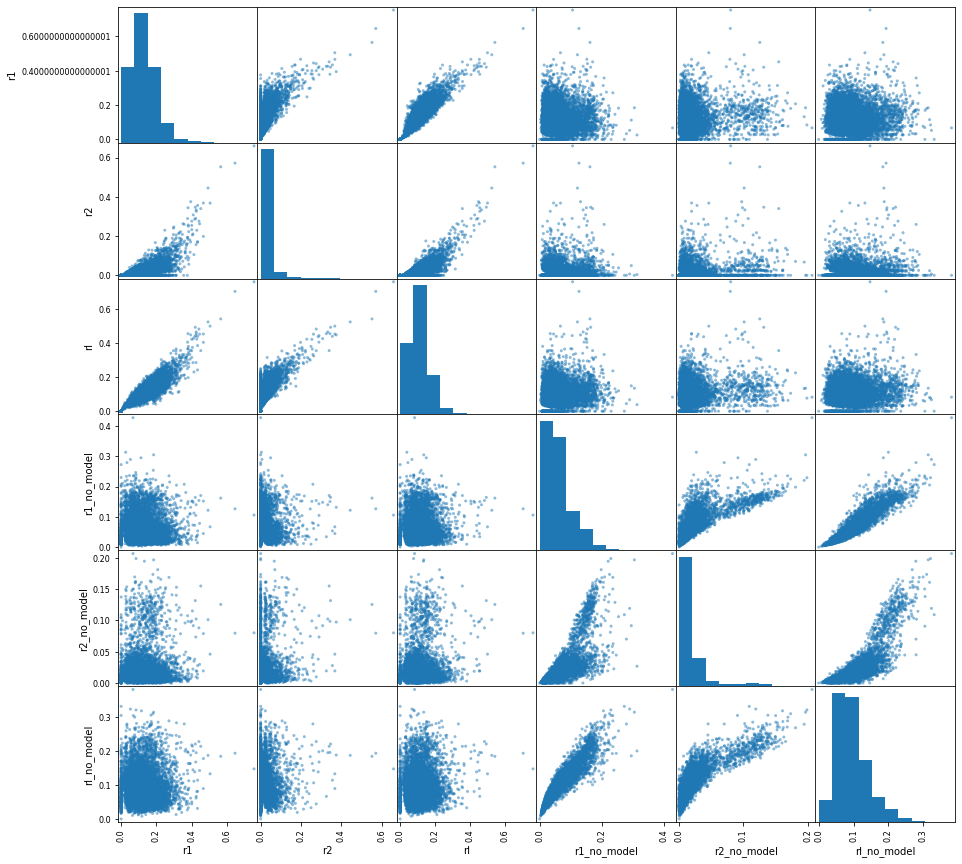

In [174]:
cols = ["r1", "r2", "rl", "r1_no_model", "r2_no_model", "rl_no_model"]
df = train[cols]
pd.plotting.scatter_matrix(df,figsize=(15,15), alpha=.5, vmin=0, vmax=1)
plt.show()

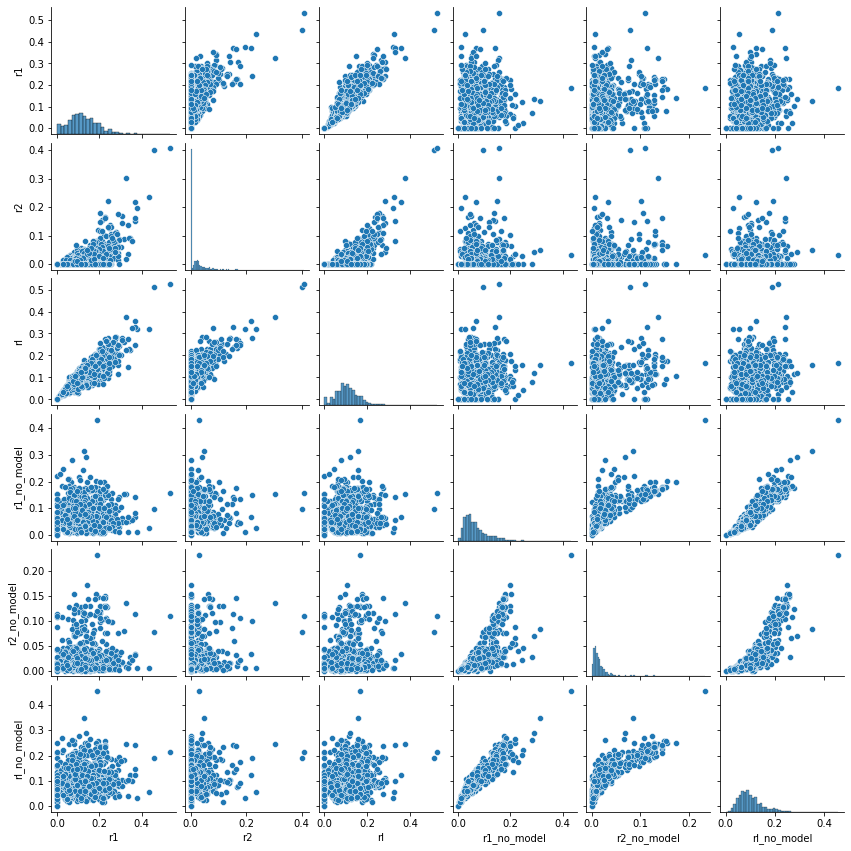

In [173]:
import seaborn as sns
df = test[cols]
sns.pairplot(df, height=2)

In [178]:
mask = ((train["tar_len"] <= 256) &
    (train["tar_len"] >= 5) &
    (train["doc_len"] <= 4096) & 
    (train["doc_len"] >= 10) &
    (train["ratio"] <= 0.3))
train[mask]["r2"].mean()

0.016713040249487346

In [32]:
filter_train = train[(
    (train["tar_len"] <= 256) &
    (train["tar_len"] >= 5) &
    ((train["doc_len"] <= 4096)) & 
    ((train["doc_len"] >= 10)) & 
    (train["2grams_prop"] >= 0.12) &
    (train["ratio"] <= 0.2)
    )]
filter_test = test[(
    (test["tar_len"] <= 256) &
    (test["tar_len"] >= 5) &
    ((test["doc_len"] <= 4096)) & 
    ((test["doc_len"] >= 10)) & 
    (test["2grams_prop"] >= 0.12) &
    (test["ratio"] <= 0.2)
    )]
print("Avg. r2:", filter_train["r2"].mean())
print("Tot.:", len(filter_train))

Avg. r2: 0.018382658481797817
Tot.: 5848


In [47]:
train["doc"] = train_doc
train["tar"] = train_tar
test["doc"] = test_doc
test["tar"] = test_tar

In [48]:
s = "This talk was given at a local TEDx event, produced independently of the TED Conferences"
def mask_string(df, s, exclude=True):
    mask = [exclude for i in range(df.shape[0])]
    for n in range(df.shape[0]):
        if s.lower() in df.iloc[n]["tar"].lower():
            mask[n] = not exclude
    return mask

In [12]:
"""tot = 0
mask_test = [True for i in test_tar]
mask_train = [True for i in train_tar]
for n, i in enumerate(test_tar):
    if s.lower() in i.lower():
        mask_test[n] = False
        tot += 1
for n, i in enumerate(train_tar):
    if s.lower() in i.lower():
        mask_train[n] = False
        tot += 1
tot"""

858

In [59]:
filter_test_mask = mask_string(test, s)
filter_train_mask = mask_string(train, s)

filter_train = train[filter_train_mask]
filter_train = filter_train[(
    (filter_train["tar_len"] <= 256) &
    (filter_train["tar_len"] >= 5) &
    (filter_train["doc_len"] <= 3000) & 
    (filter_train["doc_len"] >= 10) & 
    (filter_train["2grams_prop"] >= 0.12) &
    (filter_train["ratio"] <= 0.2)
    )]

filter_test = test[filter_test_mask]
filter_test = filter_test[(
    (filter_test["tar_len"] <= 256) &
    (filter_test["tar_len"] >= 5) &
    (filter_test["doc_len"] <= 4096) & 
    (filter_test["doc_len"] >= 10) & 
    (filter_test["2grams_prop"] >= 0.12) &
    (filter_test["ratio"] <= 0.2)
    )]

print("Avg. r2:", filter_train["r2"].mean())
print("Tot.:", len(filter_train))

Avg. r2: 0.019624362049947434
Tot.: 4319


In [56]:
with open("filter_test_documents_no_string.pkl", "wb") as f:
    pickle.dump(filter_test["doc"].tolist(), f)
with open("filter_test_targets_no_string.pkl", "wb") as f:
    pickle.dump(filter_test["tar"].tolist(), f)
with open("filter_train_documents_no_string.pkl", "wb") as f:
    pickle.dump(filter_train["doc"].tolist(), f)
with open("filter_train_targets_no_string.pkl", "wb") as f:
    pickle.dump(filter_train["tar"].tolist(), f)

In [84]:
"""def ngrams_freq(text, dim):
    count = defaultdict(int)
    text = text_tools.preprocess_case_normalization(text)
    text = text_tools.preprocess_no_punctuation(text)
    for t in text:
        t = word_tokenize(t)
        n = ngrams(t, dim, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>')
        for i in n:
            count[i] += 1
    return count

test_doc_5grams = sorted(ngrams_freq(test_doc, 5).items(), key=lambda x: x[1], reverse=True)
test_tar_5grams = sorted(ngrams_freq(test_tar, 5).items(), key=lambda x: x[1], reverse=True)
train_doc_5grams = sorted(ngrams_freq(train_doc, 5).items(), key=lambda x: x[1], reverse=True)
train_tar_5grams = sorted(ngrams_freq(train_tar, 5).items(), key=lambda x: x[1], reverse=True)

test_doc_5grams = test_doc_5grams[:1000]
test_tar_5grams = test_tar_5grams[:1000]
train_doc_5grams = train_doc_5grams[:1000]
train_tar_5grams = train_tar_5grams[:1000]"""